In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
%config InlineBackend.figure_format = 'retina'
FIGSIZE = (6, 2.5)

In [2]:
traffic = pd.read_csv("traffic.csv")
traffic["protocol"] = traffic["protocol"].astype("category")
traffic["operation"] = traffic["operation"].astype("category")

print("Total rows:", len(traffic))

Total rows: 900


In [3]:
def format_xaxis(ax, xticks=[8, 16, 32, 64, 128]):
    ax.set_xticks(xticks)
    ax.minorticks_off()
    ax.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
    ax.set_xlabel("Group size")

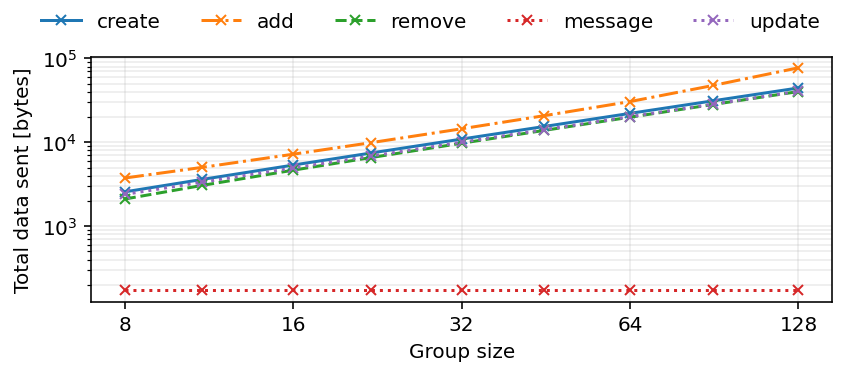

In [4]:
#
# Plot showing traffic per operation
#

def bytes_for_setup(data, ax, linestyle):
    grouped = data.groupby("groupsize", as_index=False)

    means = grouped.mean()
    errors = grouped.std()

    handle = ax.errorbar(
        x=means["groupsize"], y=means["setupsentbytes"], 
        fmt='x', ls=linestyle,
        ms=5, capsize=4)
    handle.set_label("create")

    
def bytes_for_operation(data, ax, opcode, linestyle):
    grouped = data[data.operation==opcode].groupby("groupsize", as_index=False)

    means = grouped.mean()

    handle = ax.errorbar(
        x=means["groupsize"], y=means["operationsentbytes"], 
        fmt='x', ls=linestyle,
        ms=5, capsize=4)
    handle.set_label(opcode)
    
fig = plt.figure(figsize=FIGSIZE)
ax = fig.subplots(1)

data = traffic[traffic.protocol=='FULL']
bytes_for_setup(data, ax, "-")
bytes_for_operation(data, ax, "add", "-.")
bytes_for_operation(data, ax, "remove", "--")
bytes_for_operation(data, ax, "message", ":")
bytes_for_operation(data, ax, "update", ":")
    
ax.set_xscale("log")
format_xaxis(ax)

ax.set_yscale("log")
ax.set_ylabel("Total data sent [bytes]")
ax.grid(which='both', alpha=0.25)

# ax.legend(facecolor='white', framealpha=0.5, loc="lower right", bbox_to_anchor=(1,0.1))
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', ncol=5, bbox_to_anchor=(0.97, 1.06), frameon=False)

plt.tight_layout()
plt.savefig('graph_traffic.pdf', bbox_inches='tight', pad_inches=0.075)
plt.show()

data = None

In [5]:
time = pd.read_csv("time.csv")
time["protocol"] = time["protocol"].astype("category")
time["operation"] = time["operation"].astype("category")

print("Total rows:", len(time))

Total rows: 41600


In [6]:
def time_for_setup(data, ax, linestyle):
    grouped = data.groupby("groupsize", as_index=False)

    means = grouped.mean()
    errors = grouped.std()

    handle = ax.errorbar(
        x=means["groupsize"], y=means["setuptime"], yerr=errors["setuptime"], 
        fmt='', ls=linestyle, 
        ms=5, capsize=4)
    handle.set_label("create")

    
def time_for_operation(data, ax, opcode, linestyle):
    grouped = data[data.operation==opcode].groupby("groupsize", as_index=False)

    means = grouped.mean()
    errors = grouped.std()
    
    handle = ax.errorbar(
        x=means["groupsize"], y=means["operationtime"], yerr=errors["operationtime"], 
        fmt='', ls=linestyle, 
        ms=5, capsize=4)
    handle.set_label(opcode)

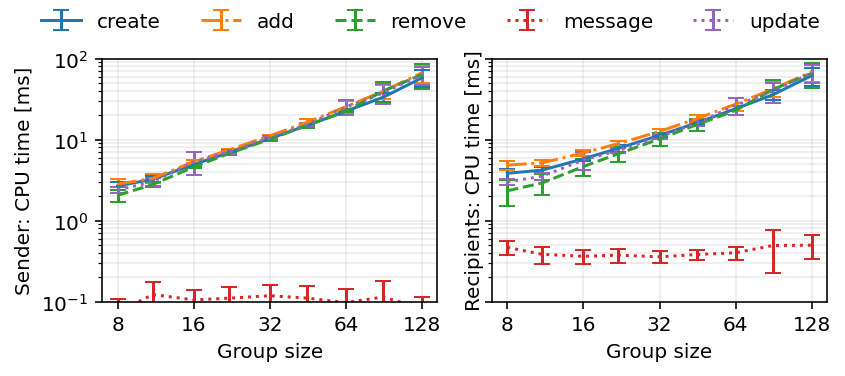

In [11]:
#
# Plot showing thread CPU per operation for sender and recipient
#

fig = plt.figure(figsize=FIGSIZE)
axes = fig.subplots(1, 2, sharey=True)
ax_sender, ax_recipient = axes[0], axes[1]

data_sender = time[(time.protocol=='FULL') & (time.clientrole=='SENDER')]
data_recipient = time[(time.protocol=='FULL') & (time.clientrole=='RECIPIENT')]

for data, ax in [(data_sender, ax_sender), (data_recipient, ax_recipient)]:
    
    time_for_setup(data, ax, "-")
    time_for_operation(data, ax, "add", "-.")
    time_for_operation(data, ax, "remove", "--")
    time_for_operation(data, ax, "message", ":")
    time_for_operation(data, ax, "update", ":")

    ax.set_xscale("log")
    format_xaxis(ax)

    ax.set_ylim((0.1, 100))
    ax.set_yscale("log")
    ax.grid(which='both', alpha=0.25)
    
#ax_sender.legend(facecolor='white', framealpha=0.5)
handles, labels = ax_sender.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', ncol=5, bbox_to_anchor=(0.97, 1.06), frameon=False)

ax_sender.set_ylabel("Sender: CPU time [ms]")
ax_recipient.set_ylabel("Recipients: CPU time [ms]")

plt.tight_layout()
plt.savefig('graph_cputime_sender_recipient.pdf', bbox_inches='tight', pad_inches=0.075)
plt.show()

In [8]:
time_facts = time[(time.groupsize==64) | (time.groupsize==128)].groupby(["groupsize", "operation", "protocol"], as_index=False)

print("Average computational effort for OPERATIONS for GS == {64, 128}:")
print()
print(time_facts.mean())

Average computational effort for OPERATIONS for GS == {64, 128}:

   groupsize operation protocol  setuptime  operationtime
0         64       add     FULL  24.063545      27.394767
1         64   message     FULL  24.074096       0.396265
2         64    remove     FULL  23.571704      22.925875
3         64    update     FULL  24.379675      26.547090
4        128       add     FULL  58.210612      68.830280
5        128   message     FULL  61.625763       0.493200
6        128    remove     FULL  67.725107      65.952474
7        128    update     FULL  59.358775      66.663128


In [9]:
time_facts = time[(time.groupsize==64) | (time.groupsize==128)].groupby(["groupsize", "protocol"], as_index=False)

print("Average compusation effort for SETUP for GS == {64, 128}:")
print()
print(time_facts.mean()['setuptime'])

Average compusation effort for SETUP for GS == {64, 128}:

0    24.022255
1    61.730064
Name: setuptime, dtype: float64


In [10]:
traffic_facts = traffic[traffic.groupsize==128].groupby(["groupsize", "operation", "protocol"], as_index=False).mean()
traffic_facts['setupsentbytes'] = traffic_facts['setupsentbytes'] / 1024
traffic_facts['operationsentbytes'] = traffic_facts['operationsentbytes'] / 1024

print("Sent bytes for operations in KiB for GS == 128:")
print()
print(traffic_facts[traffic_facts.groupsize==128])

print()
print("Total Bytes (!) Overhead (!) for sending a message:")
payloadsize = 32
print(traffic[(traffic.groupsize==128) & (traffic.operation=='message')]['operationsentbytes'].mean() - payloadsize)

Sent bytes for operations in KiB for GS == 128:

   groupsize operation protocol  setupsentbytes  operationsentbytes
0        128       add     FULL       43.412109           75.494141
1        128   message     FULL       43.412109            0.166992
2        128    remove     FULL       43.412109           39.325195
3        128    update     FULL       43.412109           39.602539

Total Bytes (!) Overhead (!) for sending a message:
139.0
